In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For basemap tiles

### 1. Data Collection

In [24]:
df = pd.read_csv("./data/nepal_forest_agb.csv")
## Basic cleaning
df = df.drop(columns=['SOC_tha'])
df = df.dropna()
# Shape of the cleaned dataframe
print(f'rows = {df.shape[0]}\ncolumns = {df.shape[1]}')
df.head()

rows = 2009
columns = 4


,plot_id,lon,lat,AGB_tha
0,10-75-3,80.413257,28.870558,454.729757
2,10-75-6,80.416333,28.870571,499.730683
3,10-84-4,80.405569,29.192646,367.626079
4,10-92-3,80.392803,29.484019,11.786484
5,10-92-4,80.395913,29.481326,77.825277


We have:

- Field-derived AGB (ton/ha) → ground truth
- Georeferenced plot centers (lat–long) → spatial linkage
- A statistically tested relationship between AGB and canopy height

Important Notes : 

- Each row in our dataset corresponds to one subplot, not an entire plot or cluster.
- AGB and SOC values are already scaled to per hectare, so the exact subplot area is mostly used to define scaling and buffering for satellite data.
- The cluster area is typically unknown or variable, unless you have a forest boundary shapefile.

In [10]:
# Split plot_id into three new columns
df[["cluster_id", "plot_id_num", "subplot_id"]] = df["plot_id"].str.split(
    "-", expand=True
)

# Optionally convert numeric columns to int
df["cluster_id"] = df["cluster_id"].astype(int)
df["plot_id_num"] = df["plot_id_num"].astype(int)
df["subplot_id"] = df["subplot_id"].astype(int)
df.head()

,plot_id,lon,lat,AGB_tha,SOC_tha,cluster_id,plot_id_num,subplot_id
0,10-75-3,80.413257,28.870558,454.729757,26.133474,10,75,3
1,10-75-4,80.416348,28.867863,NaN,2.908981,10,75,4
2,10-75-6,80.416333,28.870571,499.730683,18.360387,10,75,6
3,10-84-4,80.405569,29.192646,367.626079,78.487313,10,84,4
4,10-92-3,80.392803,29.484019,11.786484,NaN,10,92,3


In [15]:
print('Number of clusters : ', df['cluster_id'].nunique())
print("Number of plots per cluster : ", df["plot_id_num"].nunique())
print("Number of subplots per plot : ", df["subplot_id"].nunique())

Number of clusters :  195
Number of plots per cluster :  89
Number of subplots per plot :  6


<img src="images/plot-hierarchy.png" alt="Plot Hierarchy" width="800"/>

In [14]:
# Calculate subplot area from radius (m²)
df["subplot_area_m2"] = np.pi * 12.62 ** 2
# Convert to hectares
df["subplot_area_ha"] = df["subplot_area_m2"] / 10000
df.head()

,plot_id,lon,lat,AGB_tha,SOC_tha,cluster_id,plot_id_num,subplot_id,subplot_area_m2,subplot_area_ha
0,10-75-3,80.413257,28.870558,454.729757,26.133474,10,75,3,500.343869,0.050034
1,10-75-4,80.416348,28.867863,NaN,2.908981,10,75,4,500.343869,0.050034
2,10-75-6,80.416333,28.870571,499.730683,18.360387,10,75,6,500.343869,0.050034
3,10-84-4,80.405569,29.192646,367.626079,78.487313,10,84,4,500.343869,0.050034
4,10-92-3,80.392803,29.484019,11.786484,NaN,10,92,3,500.343869,0.050034


In [3]:
df.shape

(2038, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 0 to 2037
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   plot_id  2038 non-null   object 
 1   lon      2038 non-null   float64
 2   lat      2038 non-null   float64
 3   AGB_tha  2009 non-null   float64
 4   SOC_tha  1156 non-null   float64
dtypes: float64(4), object(1)
memory usage: 79.7+ KB


In [5]:
df.isnull().sum()

plot_id      0
lon          0
lat          0
AGB_tha     29
SOC_tha    882
dtype: int64

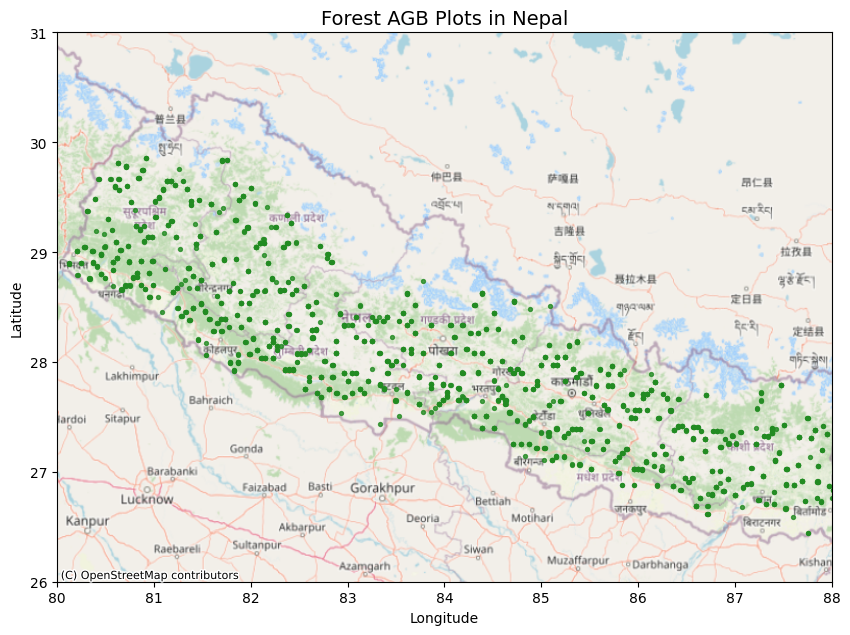

In [6]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="forestgreen", markersize=8, alpha=0.8)

# Add basemap using OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Set extent to Nepal
ax.set_xlim(80, 88)
ax.set_ylim(26, 31)

ax.set_title("Forest AGB Plots in Nepal", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

###  Determining the plot area

Our plots are described as well-distributed circular plots of 500 m² and 750 m².
That means:

- Plot area is fixed by design, not calculated from coordinates.
- The radius is:
  - 500 m² plot → r = 12.62 m
  - 750 m² plot → r = 15.45 m

So the forest area sampled per plot is already known.